In [30]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import geopandas as gpd 
import requests
import json
import geodatasets as gds
import contextily as cx
import textwrap


In [11]:

top_stations = pd.read_csv('sample.csv', usecols=['start_station_name', 'start_lat', 'start_lng', 'member_casual'])
top_stations.rename(columns={'start_station_name': 'name', 'start_lat': 'lat', 'start_lng': 'lon'}, inplace=True)
top_stations.head(10)


,name,lat,lon,member_casual
0,Bernard St & Elston Ave,41.949902,-87.713915,casual
1,McClurg Ct & Erie St,41.894352,-87.617831,member
2,Larrabee St & Division St,41.903486,-87.643353,member
3,Michigan Ave & Washington St,41.883693,-87.623919,casual
4,Loomis St & Jackson Blvd,41.877945,-87.662007,member
5,Honore St & Division St,41.903119,-87.673935,member
6,Larrabee St & North Ave,41.910210,-87.643500,member
7,Leavitt St & Chicago Ave,41.895497,-87.681910,casual
8,Wells St & Walton St,41.899930,-87.634430,member
9,Streeter Dr & Grand Ave,41.892278,-87.612043,member


In [23]:
top_stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   name           1000000 non-null  object 
 1   lat            1000000 non-null  float64
 2   lon            1000000 non-null  float64
 3   member_casual  1000000 non-null  object 
dtypes: float64(2), object(2)
memory usage: 30.5+ MB


In [26]:
# group by station and check for unique coordinates
groupy = top_stations.groupby('name')[['lat', 'lon']].nunique()
groupy.sort_values(by='lat', ascending=False).head(10)


,lat,lon
name,,
Clinton St & Madison St,2268,2278
Clinton St & Washington Blvd,2192,2208
Clark St & Elm St,2079,1984
Wells St & Concord Ln,2069,2164
Wells St & Elm St,2061,1986
Streeter Dr & Grand Ave,2016,2863
St. Clair St & Erie St,1857,1860
Canal St & Adams St,1786,1848
Wabash Ave & Grand Ave,1786,1823


In [16]:
# find top 10 stations by count
top_group = top_stations.groupby('name')['name'].agg(Count='count').sort_values(by='Count', ascending=False).head(10).reset_index()
top_group

,name,Count
0,Streeter Dr & Grand Ave,15756
1,DuSable Lake Shore Dr & Monroe St,8652
2,Michigan Ave & Oak St,8333
3,DuSable Lake Shore Dr & North Blvd,8281
4,Wells St & Concord Ln,7796
5,Clark St & Elm St,7363
6,Millennium Park,7336
7,Kingsbury St & Kinzie St,7295
8,Theater on the Lake,6966
9,Wells St & Elm St,6578


In [ ]:

# Obtain station data from Divvy API
def jprint(obj):
    text = json.dumps(obj, sort_keys=True, indent=4)
    print(text)
bike = requests.get('https://gbfs.divvybikes.com/gbfs/en/station_information.json')
bike_json = bike.json()
bike_data = bike_json['data']['stations']
station = pd.DataFrame(bike_data)

# create dataframe with station name and coordinates
stations = station[['name', 'lat', 'lon']]
stations.head(10)

,name,lat,lon
0,Stony Island Ave & 82nd St,41.746559,-87.586005
1,Cicero Ave & Flournoy St,41.872131,-87.746619
2,Marine Dr & Ainslie St,41.971600,-87.650154
3,Michigan Ave & 18th St,41.857813,-87.624550
4,Southport Ave & Waveland Ave,41.948150,-87.663940
5,Broadway & Waveland Ave,41.949074,-87.648636
6,Western Blvd & 48th Pl,41.805661,-87.683392
7,Sheridan Rd & Lawrence Ave,41.969517,-87.654691
8,Damen Ave & 51st St,41.800908,-87.674684
9,Halsted St & 37th St,41.827059,-87.645720


In [14]:
# join top 10 stations dataframe with coordinate data from API
top_station = top_group.merge(stations, on='name', how='left')
top_station.head(10)

,name,Count,lat,lon
0,Streeter Dr & Grand Ave,15756,41.892278,-87.612043
1,DuSable Lake Shore Dr & Monroe St,8652,41.880958,-87.616743
2,Michigan Ave & Oak St,8333,41.900960,-87.623777
3,DuSable Lake Shore Dr & North Blvd,8281,41.911722,-87.626804
4,Wells St & Concord Ln,7796,41.912133,-87.634656
5,Clark St & Elm St,7363,41.902973,-87.631280
6,Millennium Park,7336,41.881032,-87.624084
7,Kingsbury St & Kinzie St,7295,41.889177,-87.638506
8,Theater on the Lake,6966,41.926277,-87.630834
9,Wells St & Elm St,6578,41.903222,-87.634324


In [28]:
# create geodataframe from new top station dataframe
gdf = gpd.GeoDataFrame(top_station, geometry=gpd.points_from_xy(top_station.lon, top_station.lat), crs="EPSG:4326")
gdf.head(5)


,name,Count,lat,lon,geometry
0,Streeter Dr & Grand Ave,15756,41.892278,-87.612043,POINT (-87.61204 41.89228)
1,DuSable Lake Shore Dr & Monroe St,8652,41.880958,-87.616743,POINT (-87.61674 41.88096)
2,Michigan Ave & Oak St,8333,41.900960,-87.623777,POINT (-87.62378 41.90096)
3,DuSable Lake Shore Dr & North Blvd,8281,41.911722,-87.626804,POINT (-87.62680 41.91172)
4,Wells St & Concord Ln,7796,41.912133,-87.634656,POINT (-87.63466 41.91213)


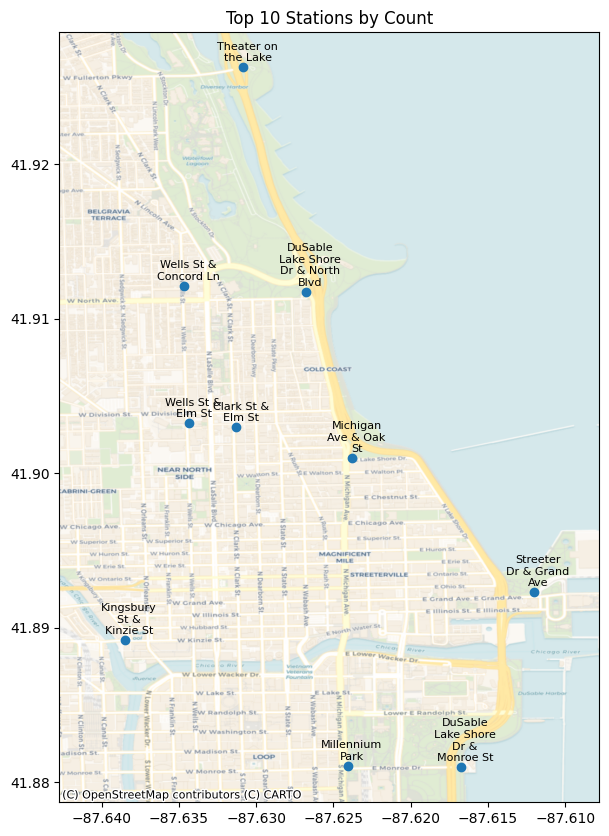

In [32]:
# plot top 10 stations on map
ax = gdf.plot(figsize=(10, 10))
cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.CartoDB.Voyager)


for i, r in gdf.iterrows():
    wrapped_text = textwrap.fill(r['name'], width=10)
    ax.annotate(wrapped_text, xy=(r.geometry.x, r.geometry.y), xytext=(3, 3), textcoords="offset points", fontsize=8, ha='center', va='bottom')

buffer_ratio = 0.1
x_range = ax.get_xlim()[1] - ax.get_xlim()[0]
ax.set_xlim(ax.get_xlim()[0] - buffer_ratio * x_range, ax.get_xlim()[1] + buffer_ratio * x_range)
plt.title('Top 10 Stations by Count')
plt.show()

In [34]:
top_stations

,name,lat,lon,member_casual
0,Bernard St & Elston Ave,41.949902,-87.713915,casual
1,McClurg Ct & Erie St,41.894352,-87.617831,member
2,Larrabee St & Division St,41.903486,-87.643353,member
3,Michigan Ave & Washington St,41.883693,-87.623919,casual
4,Loomis St & Jackson Blvd,41.877945,-87.662007,member
...,...,...,...,...
999995,Michigan Ave & 8th St,41.872769,-87.623828,casual
999996,Wells St & Polk St,41.872958,-87.633533,member
999997,Emerald Ave & 31st St,41.838195,-87.645080,member
999998,Southport Ave & Roscoe St,41.943739,-87.664020,member


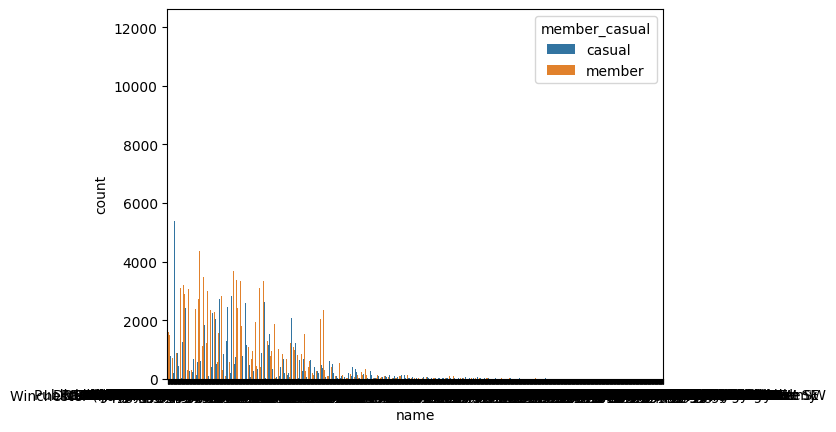

In [39]:
sns.countplot(data=top_stations, x='name', hue='member_casual')
plt.show()

In [77]:
ts = top_stations.groupby(['name', 'member_casual'], group_keys=True).size().reset_index(name='count')
ts

,name,member_casual,count
0,111th St - Morgan Park Metra,casual,1
1,111th St - Morgan Park Metra,member,1
2,2112 W Peterson Ave,casual,71
3,2112 W Peterson Ave,member,109
4,410,casual,1
...,...,...,...
2412,Yates Blvd & 75th St,casual,33
2413,Yates Blvd & 75th St,member,16
2414,Yates Blvd & 93rd St,casual,10
2415,Yates Blvd & 93rd St,member,13


In [89]:
x = top_stations.groupby('name')['member_casual'].value_counts()
x

name                          member_casual
111th St - Morgan Park Metra  member             1
                              casual             1
2112 W Peterson Ave           member           109
                              casual            71
410                           member             1
                                              ... 
Yates Blvd & 75th St          casual            33
                              member            16
Yates Blvd & 93rd St          member            13
                              casual            10
Yates Blvd & Exchange Ave     casual             3
Name: count, Length: 2417, dtype: int64

In [91]:
x = top_stations.groupby(['name', 'member_casual']).size()
x = x.groupby('name').sum().sort_values(ascending=False)
x

name
Streeter Dr & Grand Ave                    15756
DuSable Lake Shore Dr & Monroe St           8652
Michigan Ave & Oak St                       8333
DuSable Lake Shore Dr & North Blvd          8281
Wells St & Concord Ln                       7796
                                           ...  
Public Rack - Francisco Ave & Touhy Ave        1
Public Rack - Ewing Ave & 99th St              1
Stewart Ave & 123rd St                         1
Public Rack - Ewing Ave & 107th St             1
Michigan Ave & 96th St                         1
Length: 1357, dtype: int64

In [102]:
ab = []
for l in x.index:
    ab.append(l)
    
print(ab)

['Streeter Dr & Grand Ave', 'DuSable Lake Shore Dr & Monroe St', 'Michigan Ave & Oak St', 'DuSable Lake Shore Dr & North Blvd', 'Wells St & Concord Ln', 'Clark St & Elm St', 'Millennium Park', 'Kingsbury St & Kinzie St', 'Theater on the Lake', 'Wells St & Elm St']


In [104]:
plot_data = top_stations[top_stations['name'].isin(ab)]

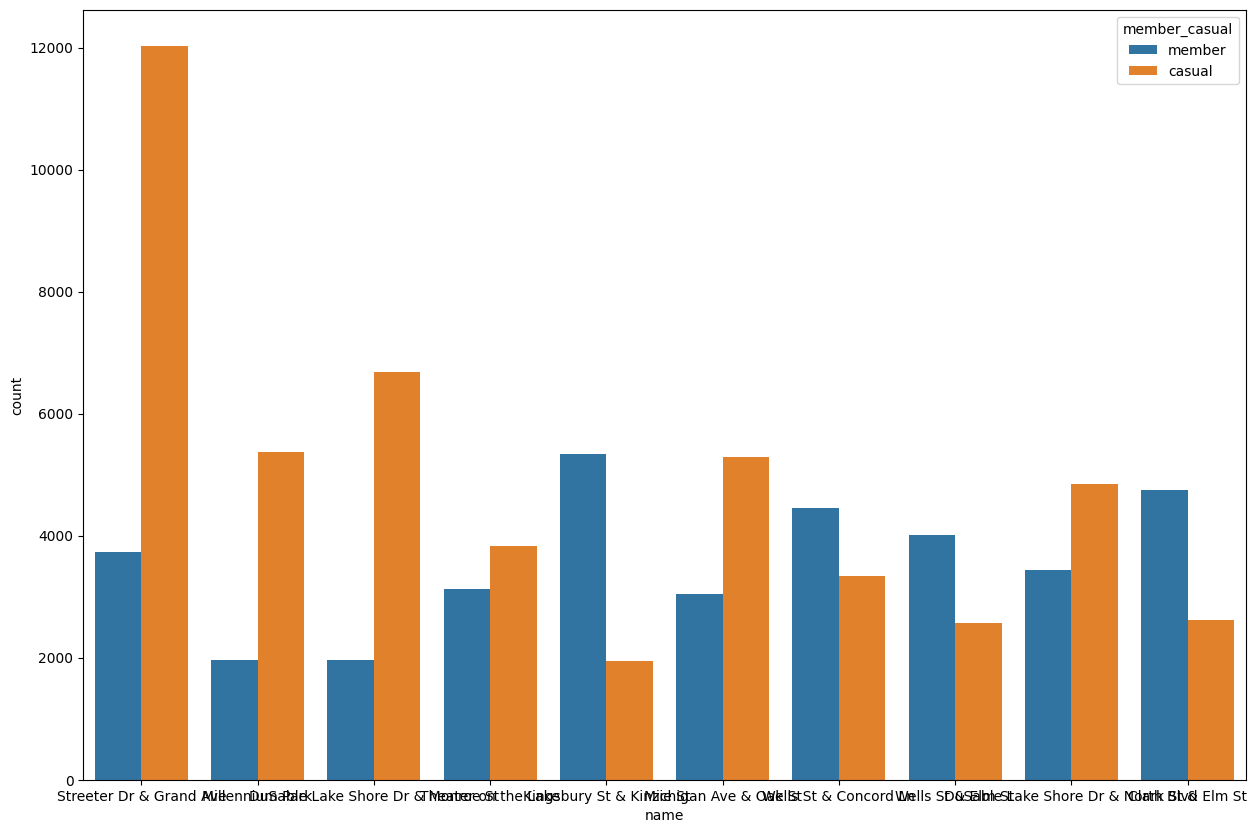

In [108]:

plt.figure(figsize=(15, 10))
sns.countplot(data=plot_data, x='name', hue='member_casual')
plt.show()

In [98]:
x = top_stations.groupby('name')['member_casual'].size().sort_values(ascending=False).head(10)


name
Streeter Dr & Grand Ave               15756
DuSable Lake Shore Dr & Monroe St      8652
Michigan Ave & Oak St                  8333
DuSable Lake Shore Dr & North Blvd     8281
Wells St & Concord Ln                  7796
Clark St & Elm St                      7363
Millennium Park                        7336
Kingsbury St & Kinzie St               7295
Theater on the Lake                    6966
Wells St & Elm St                      6578
Name: member_casual, dtype: int64


In [68]:
top_stations.set_index(['name', 'member_casual'], inplace=True)
g = top_stations.groupby(level=[0,1]).size()
g

KeyError: "None of ['name', 'member_casual'] are in the columns"

In [66]:
df1 = top_stations.groupby(['name', 'member_casual']).size()
#df2 = df1.sort_values(by='count', ascending=False)
#df3 = df2.groupby('name').head(2)
df1


name                          member_casual
111th St - Morgan Park Metra  casual             1
                              member             1
2112 W Peterson Ave           casual            71
                              member           109
410                           casual             1
                                              ... 
Yates Blvd & 75th St          casual            33
                              member            16
Yates Blvd & 93rd St          casual            10
                              member            13
Yates Blvd & Exchange Ave     casual             3
Length: 2417, dtype: int64

In [64]:
df1 = top_stations.groupby(['name', 'member_casual']).[['name', 'member_casual']]size().reset_index(name='count')
df2 = df1.sort_values(by='count', ascending=False)
#df3 = df2.groupby('name').head(2)
df2


SyntaxError: invalid syntax (2207428325.py, line 1)

KeyError: 'member_casual'

In [38]:
top_members = top_stations.groupby(['name', 'member_casual'])['member_casual'].agg(count='count').sort_values(by='count', ascending=False).reset_index().head(10)
top_members

,name,member_casual,count
0,Streeter Dr & Grand Ave,casual,12019
1,DuSable Lake Shore Dr & Monroe St,casual,6682
2,Millennium Park,casual,5370
3,Kingsbury St & Kinzie St,member,5343
4,Michigan Ave & Oak St,casual,5284
5,DuSable Lake Shore Dr & North Blvd,casual,4846
6,Clark St & Elm St,member,4748
7,Clinton St & Washington Blvd,member,4491
8,Wells St & Concord Ln,member,4460
9,Shedd Aquarium,casual,4378


In [ ]:
sns.barplot(data=top_stations, x)

In [ ]:
for i, r in gdf.iterrows():
    ax.annotate(r['name'], xy=(r.geometry.x, r.geometry.y))

In [ ]:
ax2.table(cellText=df[['Station Name', 'Count']].values, colLabels=['Station Name', 'Count'], loc='center')


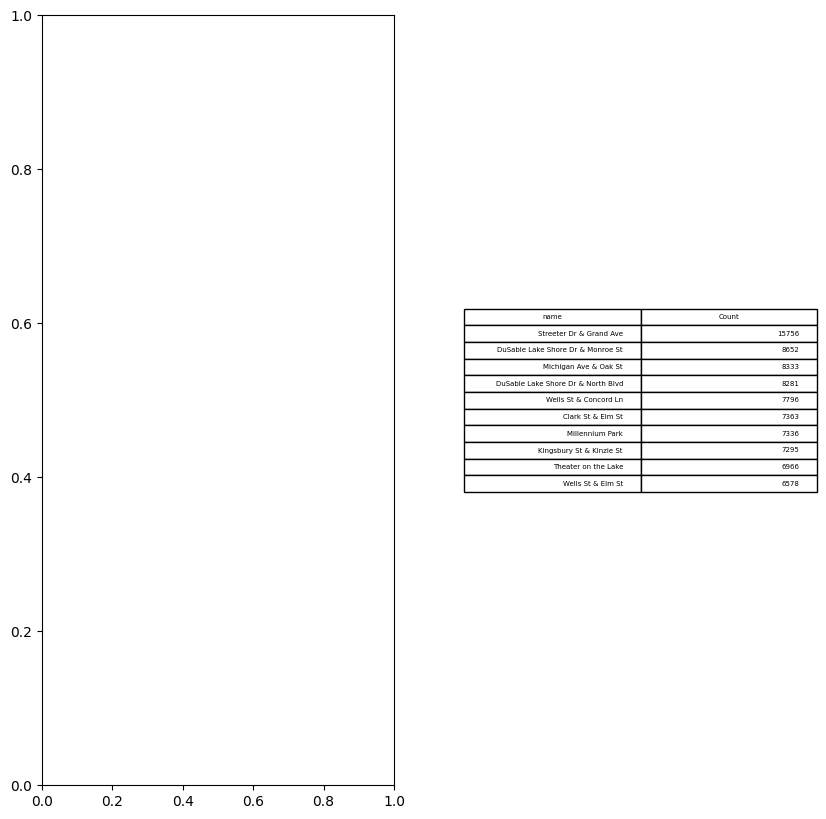

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

ax2.axis('off')
ax2.table(cellText=df2[['name', 'Count']].values, colLabels=['name', 'Count'], loc='center')


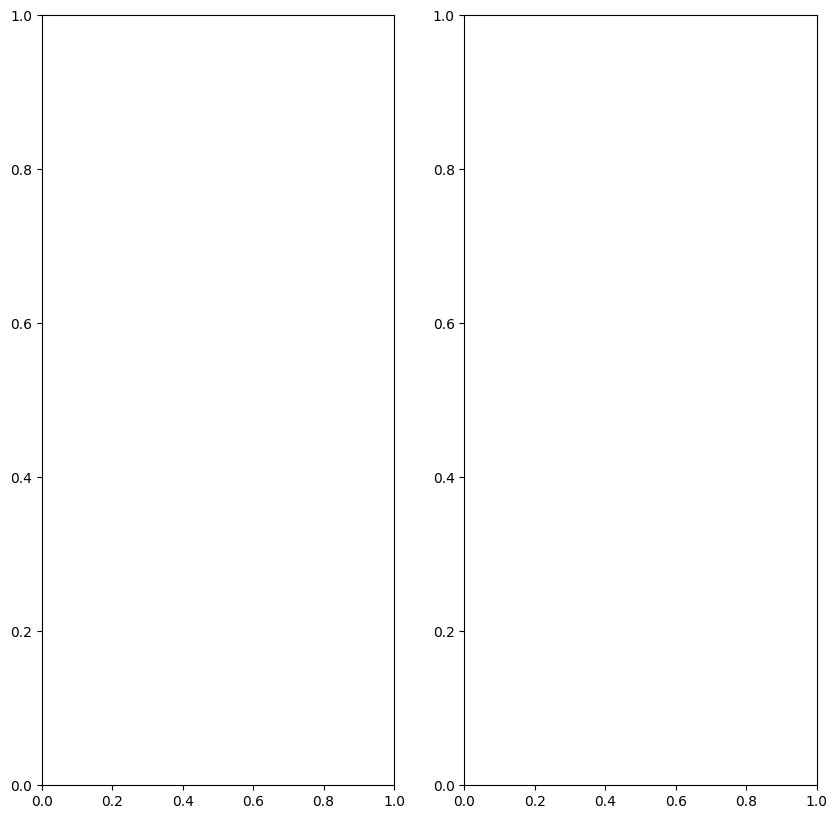

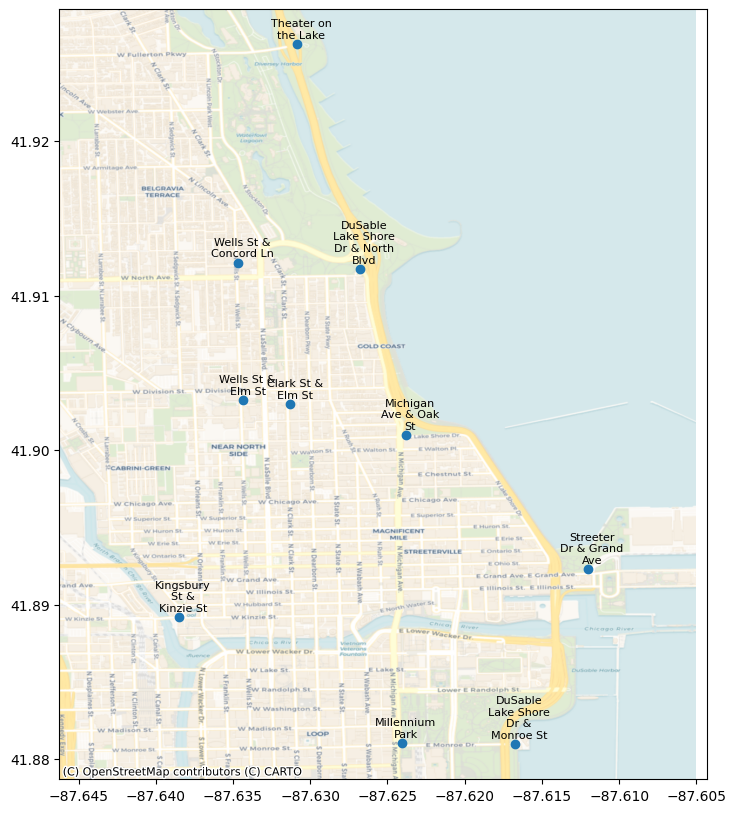

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1 = gdf.plot(figsize=(10, 10))
cx.add_basemap(ax1, crs=gdf.crs.to_string(), source=cx.providers.CartoDB.Voyager)


for i, r in gdf.iterrows():
    wrapped_text = textwrap.fill(r['name'], width=10)
    ax1.annotate(wrapped_text, xy=(r.geometry.x, r.geometry.y), xytext=(3, 3), textcoords="offset points", fontsize=8, ha='center', va='bottom')

buffer_ratio = 0.1
x_range = ax.get_xlim()[1] - ax.get_xlim()[0]
ax1.set_xlim(ax.get_xlim()[0] - buffer_ratio * x_range, ax.get_xlim()[1] + buffer_ratio * x_range)

plt.show()

# one map, one side by side bar plot

In [ ]:
chicago = gpd.read_file(gds.get_path('geoda.chicago_health'))
chicago.head(5)

In [30]:
chicago.crs

<Geographic 2D CRS: GEOGCS["WGS84(DD)",DATUM["WGS_1984",SPHEROID["WGS8 ...>
Name: WGS84(DD)
Axis Info [ellipsoidal]:
- lon[east]: Longitude (Degree)
- lat[north]: Latitude (Degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS84
- Prime Meridian: Greenwich

In [40]:
chicago.crs

<Geographic 2D CRS: GEOGCS["WGS84(DD)",DATUM["WGS_1984",SPHEROID["WGS8 ...>
Name: WGS84(DD)
Axis Info [ellipsoidal]:
- lon[east]: Longitude (Degree)
- lat[north]: Latitude (Degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS84
- Prime Meridian: Greenwich

In [ ]:
chicago.centroid.explore()

In [37]:
ax = chicago.centroid.explore()
cx.add_basemap(ax, crs=chicago.crs.to_string())

C:\Users\Andy\AppData\Local\Temp\ipykernel_22432\1963832225.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ax = chicago.centroid.explore()


AttributeError: 'Map' object has no attribute 'axis'

In [ ]:
station_list.drop(['electric_bike_surcharge_waiver', 'has_kiosk', 'rental_uris', 'eightd_has_key_dispenser', 'eightd_station_services', 'target_bike_capacity', 'target_scooter_capacity', 'region_id', 'region_code', 'client_station_id', 'rack_model'], axis=1, inplace=True)